# Mapping Print, Charting Enlightenment

## Machine Learning Experiment 1: Classifying books by titles and other metadata

Team: Rachel Hendery, Tomas Trescak, Katie McDonough, Michael Falk, Simon Burrows

## Notebook 4: Converting titles to dense matrices

Author: Michael Falk

In this notebook, we convert titles to their dense representation, as in [Notebook 2](word_vectors.ipynb). But this time with a difference: instead of taking the mean for each title, we will turn each title into a list of word vectors. Our new model, an LSTM, will be able to learn not only from what words are in the title, but also from their order.

As before, we will use Facebook's pretrained FastText French model, available here: https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md

In [1]:
# Load necessary libraries
from gensim.models import KeyedVectors
import numpy as np
import time
import random
import pandas as pd # library for manipulating data
from nltk.tokenize import wordpunct_tokenize # tokeniser
import re # regular expressions
from num2words import num2words
from matplotlib import pyplot
import pickle

C:\Users\30052372\AppData\Local\Programs\Python\Python37\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Load pre-trained word vectors
file_path = "fr_model/french_vectors.bin"
tic = time.process_time()
word_vectors = KeyedVectors.load_word2vec_format(file_path, binary = True)
toc = time.process_time()
print(f"Word vector model imported. Import took {toc - tic:.2f} seconds.")

Word vector model imported. Import took 16.15 seconds.


In [3]:
# What words can the model provide a vector for?
def does_doesnt(x):
    if x == True:
        return("does")
    else:
        return("doesn't")

print(f"The model {does_doesnt('pluie' in word_vectors.vocab)} have vectors for ordinary words like 'pluie'.")
print(f"The model {does_doesnt('Gendarme' in word_vectors.vocab)} have vectors for proper names with capital letters like 'France',")
print(f"but it {does_doesnt('voltaire' in word_vectors.vocab)} have vectors for proper names like 'voltaire'.")
print(f"The model {does_doesnt('1' in word_vectors.vocab)} have vectors for digits like '1',")
print(f"but it {does_doesnt('zéro' in word_vectors.vocab)} have vectors for accented words like 'zéro';")
print(f"and although it {does_doesnt('un' in word_vectors.vocab)} have vectors for verbalised numbers like 'un',")
print(f"it {does_doesnt('quatre-vignt' in word_vectors.vocab)} have vectors for compound numbers like 'quatre-vignt'.")
print(f"Unfortunately, the model {does_doesnt(';' in word_vectors.vocab)} have vectors for puncutation marks like ';'.")
print(f"Weirdly, it {does_doesnt('gebete' in word_vectors.vocab)} have vectors for some non-French words like 'gebete'.")

The model does have vectors for ordinary words like 'pluie'.
The model doesn't have vectors for proper names with capital letters like 'France',
but it does have vectors for proper names like 'voltaire'.
The model doesn't have vectors for digits like '1',
but it does have vectors for accented words like 'zéro';
and although it does have vectors for verbalised numbers like 'un',
it doesn't have vectors for compound numbers like 'quatre-vignt'.
Unfortunately, the model doesn't have vectors for puncutation marks like ';'.
Weirdly, it does have vectors for some non-French words like 'gebete'.


We need to do some light preprocessing of the data to account for these omissions of the model.

In [4]:
# A helper function for preprocessing
def conv_tok(string):
    # Takes a string containing digits, converts them to strings and tokenises.
    
    # First, need to handle ordinals, which have an 'e' on the end of them in French.
    if re.search('e|è', string): # if there is an 'e' or 'è' ...
        string = re.sub('\D', '', string) # ... remove it, and everything else that isn't a digit.
        num = int(string) # convert the string to an integer ...
        phrase = num2words(num, lang = 'fr', to = 'ordinal') # ... and then into a phrase
    else: # if there is no 'e' ...
        string = re.sub('\D', '', string) # ... delete any letters anyway ...
        num = int(string)
        phrase = num2words(num, lang = 'fr') # ... and don't treat it as an ordinal
    
    tokens = wordpunct_tokenize(phrase)
    reg1 = re.compile("\w") # only word characters
    words = [i for i in tokens if reg1.search(i)] # drop puncuation (e.g. hyphens)
    return(words)

In [39]:
# Import the title data
data_path = "data/editions_all_cols.csv" # locate data file
data_frame = pd.read_csv(data_path)
data = (data_frame[['super_book_code', 'full_book_title', 'parisian_keyword']]
        .dropna()
        .to_dict(orient = 'records')
       )

print(f"The data comprises {len(data)} books described by {len(data[0])} fields.")

The data comprises 3838 books described by 3 fields.


In [40]:
data[0]

{'super_book_code': 'spbk0002530',
 'full_book_title': "Abrégé de l'Histoire générale des voyages, contenant ce qu'il y a de plus remarquable, de plus utile et de mieux avéré dans les pays où les voyageurs ont pénétré; les moeurs des habitans, la religion, les usages, arts et sciences, commerce, manufactures... Par M. de La Harpe",
 'parisian_keyword': 'Histoire'}

In [41]:
tokenised_data = {} # initialise dict of processed titles

letters = re.compile("\w") # regex for finding tokens with letters
digits = re.compile("\d") # regex for finding tokens with numbers

for work in data: # loop over works
    title = work['full_book_title'].lower() # grab title, set to lower case
    tokens = wordpunct_tokenize(title) # tokenise
    
    # Dealing with numbers:
    for counter, token in enumerate(tokens): # loop over tokens in this title
        if digits.search(token): # if a numeral is found ...
            new_list = conv_tok(token) # ... convert it to a list of verbalised numbers
            tokens.remove(token) # remove the discovered digits from the token list for this title
            new_list.reverse() # reverse the list
            for num in new_list: # loop through verbalised numbers backwards ...
                tokens.insert(counter, num) # ... and add the new strings to the list
    
    # Final cleanup:
    x = [i for i in tokens if letters.search(i)] # only keep letters
    sbc = work['super_book_code']
    y = work['parisian_keyword']
    
    # Complete loop:
    tokenised_data[sbc] = {'tokens':x, 'parisian_keyword':y}

In [42]:
# Sanity check: how does a random title look?
random.choice(list(tokenised_data.items()))

('spbk0000256',
 {'tokens': ['cabinet',
   'le',
   'des',
   'fées',
   'ou',
   'collection',
   'choisie',
   'des',
   'contes',
   'des',
   'fées',
   'et',
   'autres',
   'contes',
   'merveilleux'],
  'parisian_keyword': 'Belles-Lettres'})

Now we need to find word vectors for all the words in all the titles. This will create a megalist that we can pickle and pass to the colab notebook.

In [43]:
for sbc, work in tokenised_data.items(): # loop over superbooks
    vectors = [] # initialise vector list
    for token in work['tokens']: # loop over tokens
        if token in word_vectors.vocab: # if the word is in the vocab ...
            vectors.append(word_vectors[token]) # ... add its vector to the list
    tokenised_data[sbc]['vectors'] = vectors

In [44]:
# Sanity check
random.choice(list(tokenised_data.items()))

('spbk0004483',
 {'tokens': ['mémoires',
   'pour',
   'servir',
   'à',
   'l',
   'histoire',
   'du',
   'maréchal',
   'duc',
   'de',
   'luxembourg',
   'depuis',
   'sa',
   'naissance',
   'en',
   'mille',
   'six',
   'cent',
   'vingt',
   'huit',
   'jusqu',
   'à',
   'sa',
   'mort',
   'en',
   'mille',
   'six',
   'cent',
   'quatre',
   'vingt',
   'quinze'],
  'parisian_keyword': 'Science et Arts',
  'vectors': [array([-6.1897e-01,  1.4812e-01, -2.1926e-01, -2.1838e-01,  1.3079e-01,
          -2.2188e-01, -2.3237e-01,  4.7817e-01, -3.3054e-01,  3.3715e-01,
           7.1880e-02,  4.3349e-02, -1.5864e-01, -9.3962e-02, -9.7046e-02,
          -1.4100e-02,  1.6012e-01, -5.4899e-02,  1.7805e-01, -7.1406e-01,
          -2.3453e-01, -3.2571e-01, -4.1750e-01,  2.2193e-01, -6.5041e-02,
           3.5041e-01,  7.3853e-02, -1.9645e-01,  7.9821e-02, -2.4866e-01,
           4.5924e-01,  1.3757e-01,  1.0438e-01,  1.2465e-01, -1.6306e-01,
          -1.3742e-01,  1.9715e-01,  3.0462

Finally we need to reshape the vector data for each title into a rank-three tensor that can be passed to Tensorflow.

135 of the books have a title more than 40 words long.
11 have a title 0 words long (i.e. no useable data).
There are 3378 books in the dataset.


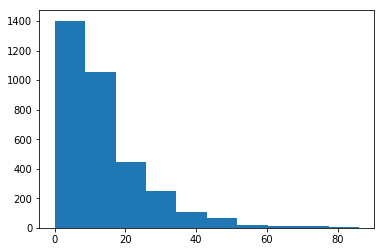

In [45]:
# How long are the titles?
lengths = np.array([len(book['vectors']) for key, book in tokenised_data.items()])
pyplot.hist(lengths)
over_forty = np.where(lengths > 40)[0].shape[0]
under_one = np.where(lengths < 1)[0].shape[0]
print(f"{over_forty} of the books have a title more than 40 words long.")
print(f"{under_one} have a title 0 words long (i.e. no useable data).")
print(f"There are {len(tokenised_data)} books in the dataset.")

In [46]:
# Get rid of useless records
# Only keep entries from tokenised_data if FastText has been able to generate at least one word vector
tokenised_data = {key:value for key, value in tokenised_data.items() if len(value['vectors']) > 0}
len(tokenised_data)

3367

In [196]:
# Now reshape the word vector data.

# Calculate the dimensions of the data:
m = len(tokenised_data)
print(f"There are {m} training examples in the dataset.")
thresh = 95
max_len = int(np.percentile(lengths, thresh))
print(f"{thresh}% of the titles have a length of {max_len} or less, so this has been chosen as the truncation point.")
v = word_vectors.vector_size
print(f"Each word is represented by a {v}-dimensional vector.")
classes = data_frame['parisian_keyword'].dropna().unique().tolist() # get unique classes
classes = {x:y for y,x in enumerate(classes)} # convert to dictionary for encoding
num_classes = len(classes)
print(f"The books have been sorted into {num_classes} categories.")

# Now reshape all the data to produce X, Y and indices.
X = np.zeros(shape = (m, max_len, v)) # initialise X with correct dimensions.
Y = np.zeros(shape = (m, num_classes)) # initialise Y with correct dimensions.
indices = [] # initialise indices list for reference

for i, key in enumerate(tokenised_data):
    
    # Save the super_book_code in the indices array:
    indices.append(key)
    
    # Get the word vectors and add them to X:
    vectors = tokenised_data[key]['vectors']
    for j, v in enumerate(vectors):
        if j == max_len: # stop adding vectors once the max length is reached
            break
        else:
            X[i,j,:] = vectors[j]
    
    # One-hot encode the y-value:
    keyword = tokenised_data[key]['parisian_keyword']
    Y[i,labels[keyword]] = 1

print("\n")
print(f"X is a rank {len(X.shape)} tensor of dimensions {X.shape}")
print(f"Y is a rank {len(Y.shape)} tensor of dimensions {Y.shape}")
print(f"indices is a list of {len(indices)} super_book_codes.")

There are 3367 training examples in the dataset.
95% of the titles have a length of 39 or less, so this has been chosen as the truncation point.
Each word is represented by a 300-dimensional vector.
The books have been sorted into 6 categories.


X is a rank 3 tensor of dimensions (3367, 39, 300)
Y is a rank 2 tensor of dimensions (3367, 6)
indices is a list of 3367 super_book_codes.


In [185]:
# Sanity check: has the zero-padding worked for X?
X[random.randint(0,X.shape[0]-1),:,:]

array([[-0.05129   ,  0.31696001, -0.29642999, ...,  0.051341  ,
         0.35515001,  0.25327   ],
       [-0.074464  , -0.018784  , -0.11756   , ...,  0.15008999,
        -0.083511  , -0.091129  ],
       [-0.15436999,  0.11171   ,  0.022948  , ...,  0.021554  ,
         0.28105   ,  0.031143  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [243]:
# Sanity check: has the one-hot encoding worked for Y?
# (Run the cell a few times to see that the encoding is consistent.)
r = random.randint(0, Y.shape[0]-1)
print(tokenised_data[indices[r]]['parisian_keyword'])
print(Y[r,:])

Jurisprudence
[0. 0. 0. 0. 0. 1.]


Now that the preprocessing is complete, we can pickle the training data, ready to feed into our new RNN.

In [244]:
training_dict = {'X':X, 'Y':Y, 'indices':indices, 'data':data_frame}

with open('data/rnn_data.p', 'wb') as f:
    pickle.dump(training_dict, f)